# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Training the agent

To train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [6]:
from dqn_agent import Agent
# init the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

### 5. Learning Algorithm

The DQN algorithm is used to train the agent. It uses a fully connected neural network (NN) layers as a function approximator for the Q function. The NN consists of two hidden layers, each with 64 units. The input layer receives the states with 37 units and the output layer has four units for the possible actions.
```
QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
) 
```

The agents uses two identical architecture NNs to learn through interactions with the envrionment. The first, which is refered to as local QNetwork, is used to train the agent. The second, which is the target QNetwork, is used only in the error calculation to make the training process more stable.

The algorithm performs and repeats two main tasks, which are:
1. The sampling process:
    - The agent chooses an action from the state using a given policy.
        - The action is chosen using the $\epsilon-greedy$ algorithm where the next best action has 
           the highest probabilty to be selected and low $\epsilon$ probability for all other actions.
    - The agent takes the action and receives new data from the environment. The data is in form of tuples `(next_state, reward, done)`. 
    - Store its experience tuple in a replay memory.
    - Set state to the next state.
2. The learning process:
    - Obtain a random batch of tuples from the replay memory.
    - Use the target QNetwork to get the target value.
    ```
    target = rewards + (gamma * Q_targets_next * (1 - dones))
    ```
    - Use the local QNetwork to get the expected value.
    - Calculate the MSE between both returned values. 
    - Do an optimization step to change the weights of the local network.
    - Do a soft update 

Near the end and if the agent learned successfully, it will choose the best possible action at each state.  

The parameters I chose for the DQN are as follows:
```
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
```

And for the $\epsilon$-greedy algorithm:
```
eps_start = 1.0         # starting value of epsilon
eps_end = 0.01          # minimum value of epsilon
eps_decay = 0.995       # multiplicative factor (per episode) for decreasing epsilon
```

In [7]:
from collections import deque
import matplotlib.pyplot as plt
import torch

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    best_score = 13.0
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=best_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            best_score = np.mean(scores_window)
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = dqn()

Episode 100	Average Score: 0.95
Episode 200	Average Score: 4.79
Episode 300	Average Score: 7.36
Episode 400	Average Score: 10.17
Episode 496	Average Score: 13.01
Environment solved in 396 episodes!	Average Score: 13.01
Episode 497	Average Score: 13.01
Environment solved in 397 episodes!	Average Score: 13.01
Episode 498	Average Score: 13.09
Environment solved in 398 episodes!	Average Score: 13.09
Episode 499	Average Score: 13.09
Environment solved in 399 episodes!	Average Score: 13.09
Episode 500	Average Score: 13.24

Environment solved in 400 episodes!	Average Score: 13.24
Episode 503	Average Score: 13.28
Environment solved in 403 episodes!	Average Score: 13.28
Episode 504	Average Score: 13.33
Environment solved in 404 episodes!	Average Score: 13.33
Episode 505	Average Score: 13.35
Environment solved in 405 episodes!	Average Score: 13.35
Episode 511	Average Score: 13.37
Environment solved in 411 episodes!	Average Score: 13.37
Episode 514	Average Score: 13.41
Environment solved in 414 e

Clearly, the agent was able to solve the environment in episode 396. But it achieved its best score in episode 759.

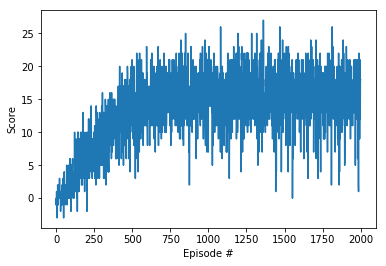

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()

Although the model has a great score and performance, but it can be further improved by trying other algorithms like:
- Double DQN
- Prioritized Experience Replay
- Dueling DQN
- Pixel Based Learning